In [ ]:
!pip install scikit-learn-extra

In [1]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import  NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

In [2]:
uploaded = files.upload()
filename = next(iter(uploaded))
df_train = pd.read_csv(io.BytesIO(uploaded[filename]))

Saving sm.csv to sm.csv


In [3]:
df_train.head()

,Campaign_ID,Target_Audience,Campaign_Goal,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROI,Location,Language,Clicks,Impressions,Engagement_Score,Customer_Segment,Date,Company
0,904530,Men 18-24,Market Expansion,15 Days,Facebook,0.09,"$3,036.83",5.09,Las Vegas,French,7475,23660,4,Home,28-02-2022,Living Luxe
1,927546,Men 25-34,Market Expansion,15 Days,Facebook,0.04,"$3,037.01",2.55,Los Angeles,French,7475,23661,6,Technology,19-07-2022,Giga Geeks
2,984827,Men 18-24,Increase Sales,15 Days,Twitter,0.10,"$3,037.06",0.88,Austin,English,7475,23661,3,Food,16-10-2022,Culinary Quest
3,109864,Women 25-34,Increase Sales,15 Days,Twitter,0.02,"$3,037.06",0.95,Los Angeles,Spanish,7475,23661,3,Fashion,16-12-2022,Attire Artistry
4,336436,All Ages,Increase Sales,15 Days,Twitter,0.14,"$3,037.08",1.37,New York,English,7475,23662,9,Food,23-10-2022,Epicurean Edge


In [4]:
df_train.shape

(102105, 16)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102105 entries, 0 to 102104
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Campaign_ID       102105 non-null  int64  
 1   Target_Audience   102105 non-null  object 
 2   Campaign_Goal     102105 non-null  object 
 3   Duration          102105 non-null  object 
 4   Channel_Used      102105 non-null  object 
 5   Conversion_Rate   102105 non-null  float64
 6   Acquisition_Cost  102105 non-null  object 
 7   ROI               102105 non-null  float64
 8   Location          102105 non-null  object 
 9   Language          102105 non-null  object 
 10  Clicks            102105 non-null  int64  
 11  Impressions       102105 non-null  int64  
 12  Engagement_Score  102105 non-null  int64  
 13  Customer_Segment  102105 non-null  object 
 14  Date              102105 non-null  object 
 15  Company           102105 non-null  object 
dtypes: float64(2), int64

In [6]:
df_train.describe()

,Campaign_ID,Conversion_Rate,ROI,Clicks,Impressions,Engagement_Score
count,102105.000000,102105.000000,102105.000000,102105.000000,102105.000000,102105.000000
mean,550515.839293,0.079994,3.170981,13857.367612,43098.528074,4.371500
std,260881.788294,0.040576,2.456158,5357.292671,15542.117539,3.151373
min,100001.000000,0.010000,0.000000,4390.000000,15277.000000,1.000000
25%,323857.000000,0.050000,0.930000,9455.000000,30258.000000,1.000000
50%,551448.000000,0.080000,2.670000,12625.000000,40017.000000,4.000000
75%,777186.000000,0.110000,5.310000,19035.000000,57903.000000,7.000000
max,999998.000000,0.150000,8.000000,23518.000000,71181.000000,10.000000


In [7]:
df_train['Channel_Used'].value_counts()

,count
Channel_Used,
Facebook,25628
Instagram,25617
Pinterest,25514
Twitter,25346


Data Preprocessing

In [8]:
df_train[['Gender', 'Age_Range']] = df_train['Target_Audience'].str.split(expand=True)
df_train.drop('Target_Audience', axis=1, inplace=True)
df_train['Age_Range'] = df_train['Age_Range'].replace('Ages', '18-60')
df_train['Date'] = pd.to_datetime(df_train['Date'])

<ipython-input-8-086eb924f846>:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_train['Date'] = pd.to_datetime(df_train['Date'])


In [9]:
df_train.isnull().sum()

,0
Campaign_ID,0
Campaign_Goal,0
Duration,0
Channel_Used,0
Conversion_Rate,0
Acquisition_Cost,0
ROI,0
Location,0
Language,0
Clicks,0


In [10]:
for col in df_train.columns:
   print(col, df_train[col].unique())

Campaign_ID [904530 927546 984827 ... 317569 419298 764257]
Campaign_Goal ['Market Expansion' 'Increase Sales' 'Product Launch' 'Brand Awareness']
Duration ['15 Days' '30 Days' '45 Days']
Channel_Used ['Facebook' 'Twitter' 'Pinterest' 'Instagram']
Conversion_Rate [0.09 0.04 0.1  0.02 0.14 0.05 0.11 0.13 0.08 0.06 0.12 0.15 0.07 0.03
 0.01]
Acquisition_Cost ['$3,036.83' '$3,037.01' '$3,037.06' ... '$8,958.81' '$8,958.84'
 '$8,958.91']
ROI [5.09       2.55       0.88       ... 0.17874726 0.72392642 0.95987281]
Location ['Las Vegas' 'Los Angeles' 'Austin' 'New York' 'Miami']
Language ['French' 'English' 'Spanish']
Clicks [ 7475  4390  7476 ... 23517 13812 23518]
Impressions [23660 23661 23662 ... 71179 71180 71181]
Engagement_Score [ 4  6  3  9  1  2 10  8  7  5]
Customer_Segment ['Home' 'Technology' 'Food' 'Fashion' 'Health']
Date <DatetimeArray>
['2022-02-28 00:00:00', '2022-07-19 00:00:00', '2022-10-16 00:00:00',
 '2022-12-16 00:00:00', '2022-10-23 00:00:00', '2022-11-04 00:00:00',
 '2

In [11]:
min_date = df_train['Date'].min()
max_date = df_train['Date'].max()
print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2022-01-01 00:00:00
Maximum date: 2022-12-31 00:00:00


the date column has 365 values, it would be easier to get months and use that for visualization

In [12]:
df_train['month_name'] = df_train['Date'].dt.month_name()
df_train['year'] = df_train['Date'].dt.year
df_train['day'] = df_train['Date'].dt.day
df_train['month'] = df_train['Date'].dt.month
df_train.drop('Date', axis=1, inplace=True)

In [13]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

df_train['month_name'] = pd.Categorical(df_train['month_name'], categories=month_order, ordered=True)

df_train['month_name'].unique()

['February', 'July', 'October', 'December', 'November', ..., 'January', 'May', 'March', 'September', 'August']
Length: 12
Categories (12, object): ['January' < 'February' < 'March' < 'April' ... 'September' < 'October' <
                          'November' < 'December']

In [14]:
df_train['Duration']= df_train['Duration'].str.replace('Days', '')
df_train['Duration'] = df_train['Duration'].astype(int)
df_train['Acquisition_Cost'] = df_train['Acquisition_Cost'].str.replace('$', '')
df_train['Acquisition_Cost'] = df_train['Acquisition_Cost'].str.replace(',', '')
df_train['Acquisition_Cost'] = df_train['Acquisition_Cost'].astype(float)

Additional columns

In [15]:
df_train['Cost_per_conversion'] = df_train.Acquisition_Cost/df_train.Conversion_Rate
df_train['ROI_ratio'] = df_train.ROI/df_train.Duration
df_train.head(5)

,Campaign_ID,Campaign_Goal,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROI,Location,Language,Clicks,...,Customer_Segment,Company,Gender,Age_Range,month_name,year,day,month,Cost_per_conversion,ROI_ratio
0,904530,Market Expansion,15,Facebook,0.09,3036.83,5.09,Las Vegas,French,7475,...,Home,Living Luxe,Men,18-24,February,2022,28,2,33742.555556,0.339333
1,927546,Market Expansion,15,Facebook,0.04,3037.01,2.55,Los Angeles,French,7475,...,Technology,Giga Geeks,Men,25-34,July,2022,19,7,75925.250000,0.170000
2,984827,Increase Sales,15,Twitter,0.10,3037.06,0.88,Austin,English,7475,...,Food,Culinary Quest,Men,18-24,October,2022,16,10,30370.600000,0.058667
3,109864,Increase Sales,15,Twitter,0.02,3037.06,0.95,Los Angeles,Spanish,7475,...,Fashion,Attire Artistry,Women,25-34,December,2022,16,12,151853.000000,0.063333
4,336436,Increase Sales,15,Twitter,0.14,3037.08,1.37,New York,English,7475,...,Food,Epicurean Edge,All,18-60,October,2022,23,10,21693.428571,0.091333


Encoding categorical features

In [16]:
le = LabelEncoder()
df_train['Campaign_Goal_encoded'] = le.fit_transform(df_train['Campaign_Goal'])
df_train['Channel_Used_encoded'] = le.fit_transform(df_train['Channel_Used'])
frequency_encoding1 = df_train['Location'].value_counts().to_dict()
df_train['Location_encoded'] = df_train['Location'].map(frequency_encoding1)
df_train['Language_encoded'] = le.fit_transform(df_train['Language'])
df_train['Customer_Segment_encoded'] = le.fit_transform(df_train['Customer_Segment'])
frequency_encoding2 = df_train['Company'].value_counts().to_dict()
df_train['Company_encoded'] = df_train['Company'].map(frequency_encoding2)
df_train['Age_Range_encoded'] = le.fit_transform(df_train['Age_Range'])
df_train = pd.get_dummies(df_train, columns=['Gender'], drop_first=True)


In [17]:
df_train.Gender_Men = df_train.Gender_Men.astype(int)
df_train.Gender_Women = df_train.Gender_Women.astype(int)
df_train.loc[(df_train['Gender_Men'] == 0) & (df_train['Gender_Women'] == 0), ['Gender_Men', 'Gender_Women']] = 1

Visualization

<Axes: title={'center': 'Impressions over time'}, xlabel='month', ylabel='Impressions'>

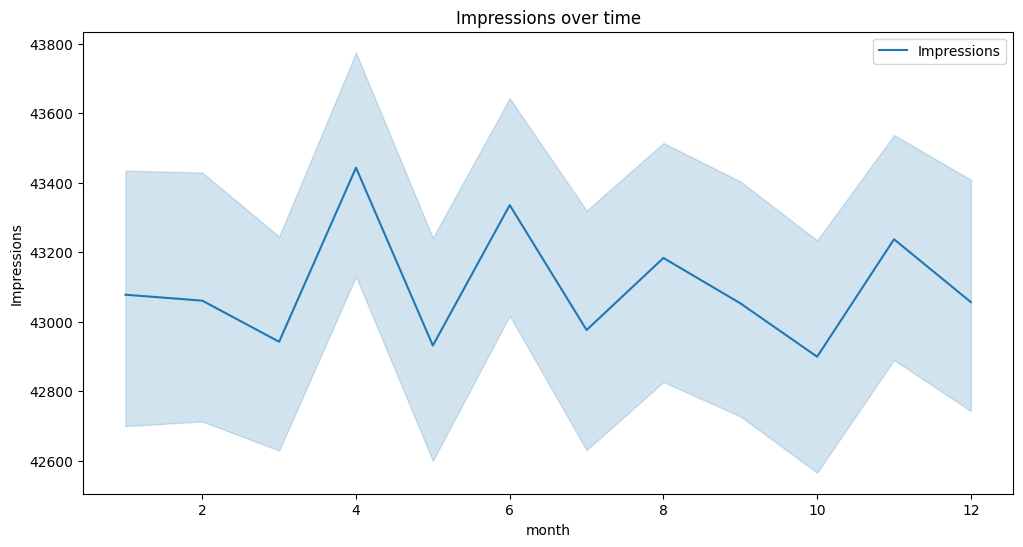

In [18]:
plt.figure(figsize=(12,6))
plt.title("Impressions over time")
sns.lineplot(x=df_train['month'], y=df_train['Impressions'], label="Impressions")

the months with the highest delivery were March, June and September

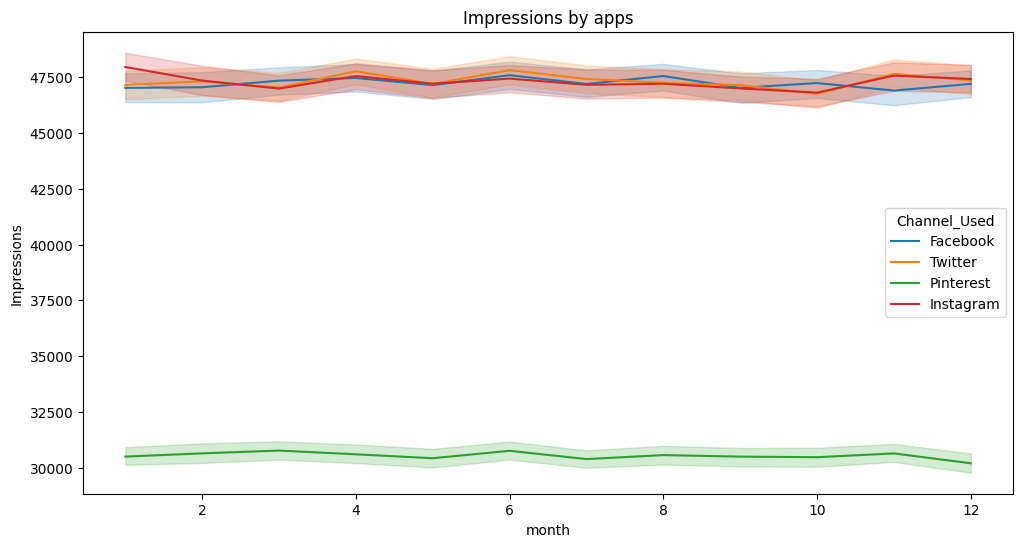

In [19]:
plt.figure(figsize=(12,6))
plt.title("Impressions by apps")
sns.lineplot(data=df_train, x='month', y='Impressions', hue='Channel_Used')

plt.xlabel('month')
plt.ylabel('Impressions')
plt.legend(title='Channel_Used')

pintrest has very few impression

<ipython-input-20-080d3f98dd67>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_train['Channel_Used'], y=df_train['Clicks'], palette=palette)


Text(0, 0.5, 'Clicks')

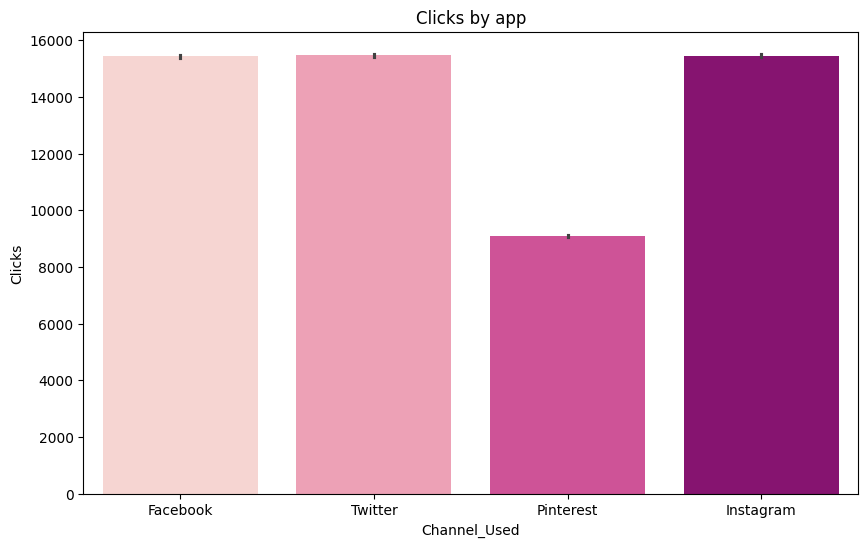

In [20]:
plt.figure(figsize=(10,6))

plt.title("Clicks by app")
palette = "RdPu"

sns.barplot(x=df_train['Channel_Used'], y=df_train['Clicks'], palette=palette)
plt.ylabel("Clicks")

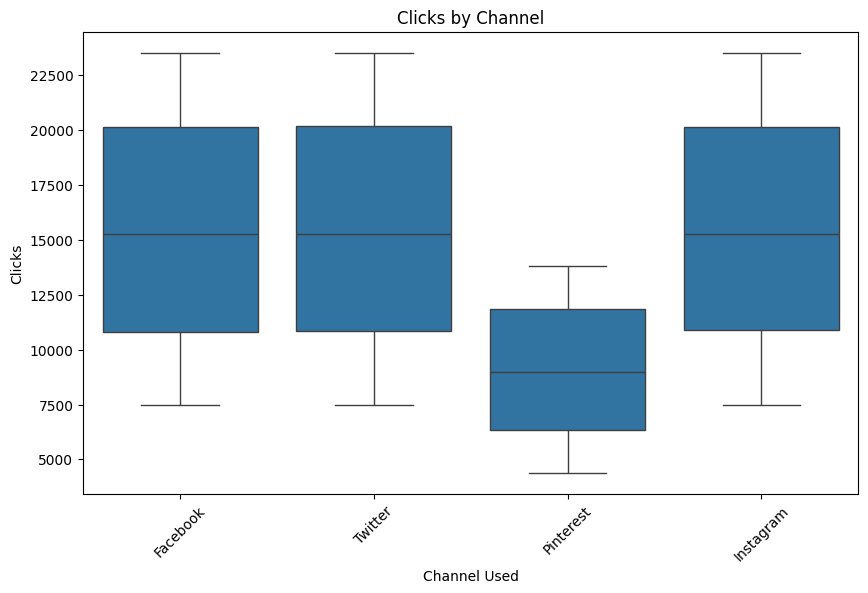

In [21]:
plt.figure(figsize=(10, 6))
plt.title("Clicks by Channel")
sns.boxplot(data=df_train, x='Channel_Used', y='Clicks')
plt.xlabel('Channel Used')
plt.ylabel('Clicks')
plt.xticks(rotation=45)
plt.show()

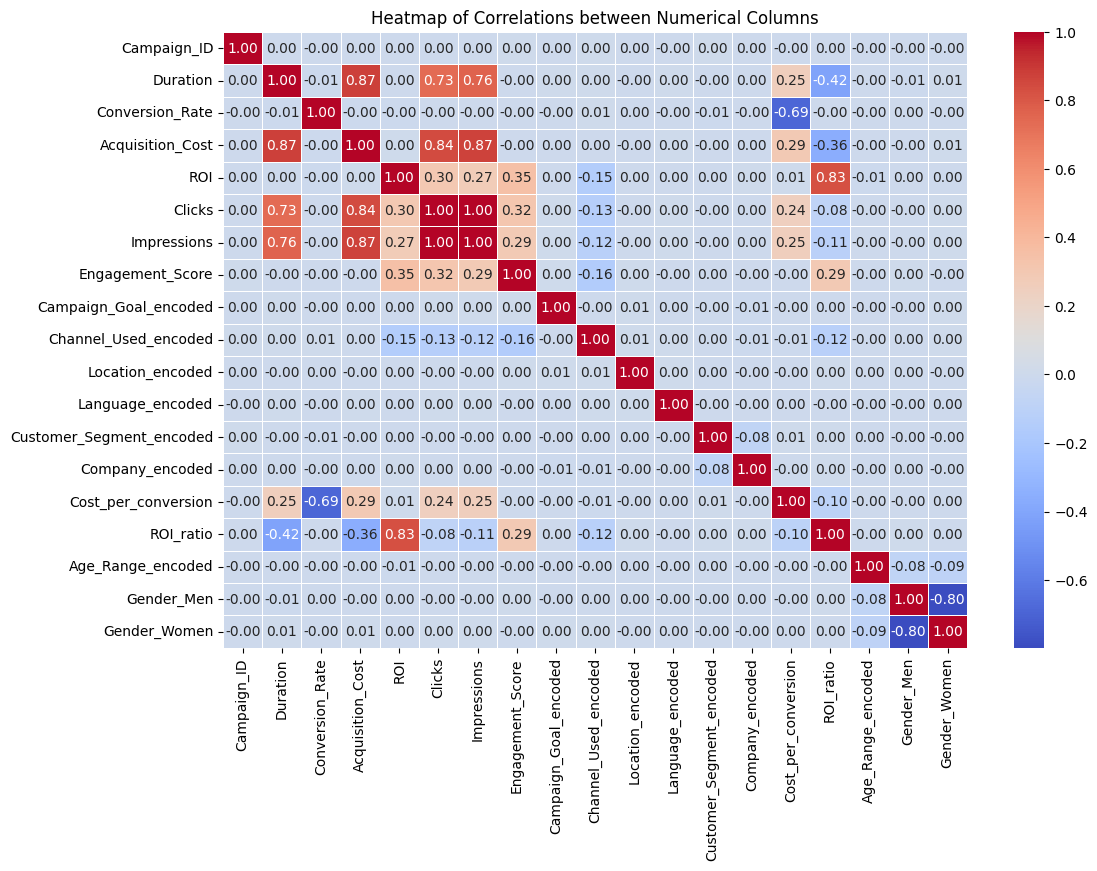

In [ ]:
numeric_columns = df_train.select_dtypes(include=['float64', 'int64']).columns

corr_matrix = df_train[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Heatmap of Correlations between Numerical Columns')
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October'),
  Text(10, 0, 'November'),
  Text(11, 0, 'December')])

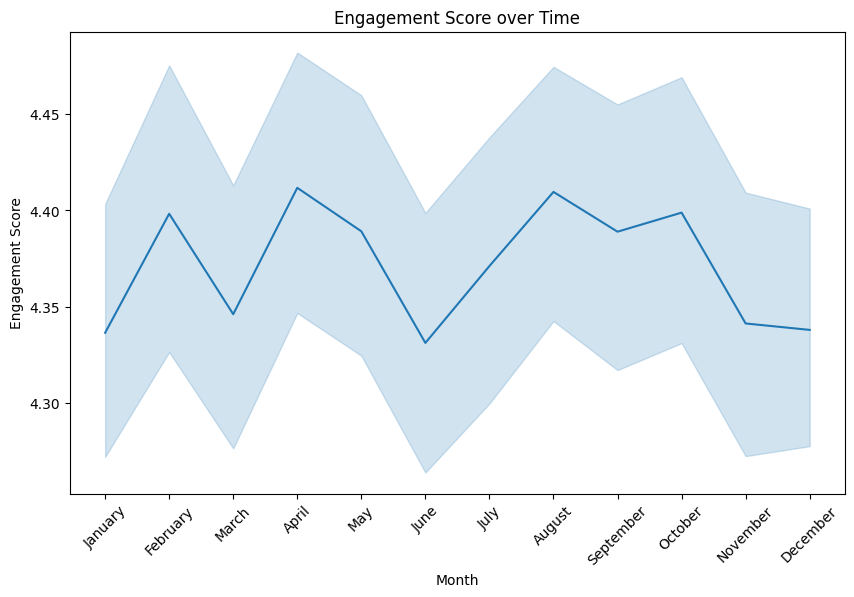

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x=df_train['month_name'], y=df_train['Engagement_Score'])
plt.title('Engagement Score over Time')
plt.xlabel('Month')
plt.ylabel('Engagement Score')
plt.xticks(rotation=45)

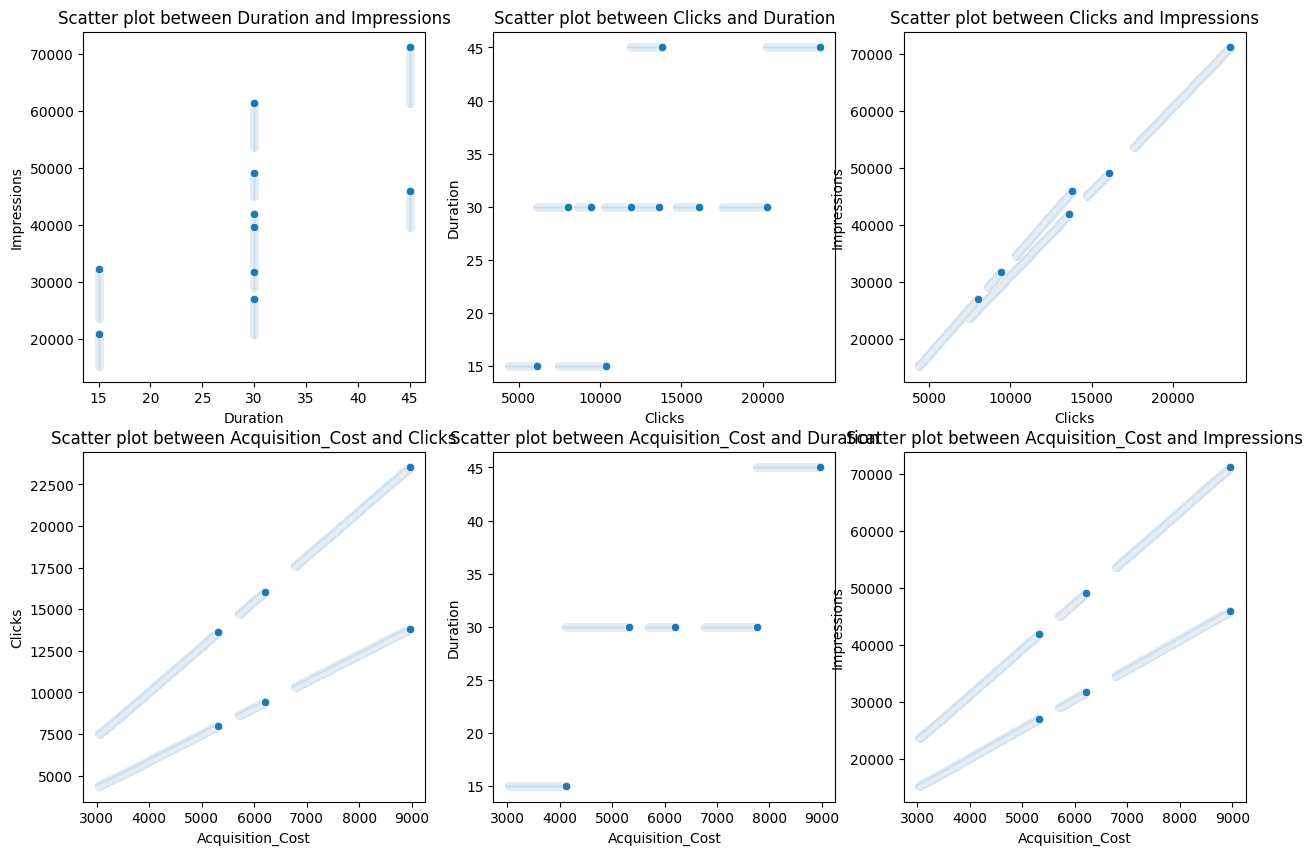

In [ ]:
pairs = [
    ('Duration', 'Impressions'),
    ('Clicks', 'Duration'),
    ('Clicks', 'Impressions'),
    ('Acquisition_Cost', 'Clicks'),
    ('Acquisition_Cost', 'Duration'),
    ('Acquisition_Cost', 'Impressions')
]

plt.figure(figsize=(15, 10))
for i, (col1, col2) in enumerate(pairs, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df_train, x=col1, y=col2)
    plt.title(f'Scatter plot between {col1} and {col2}')
    plt.xlabel(col1)
    plt.ylabel(col2)

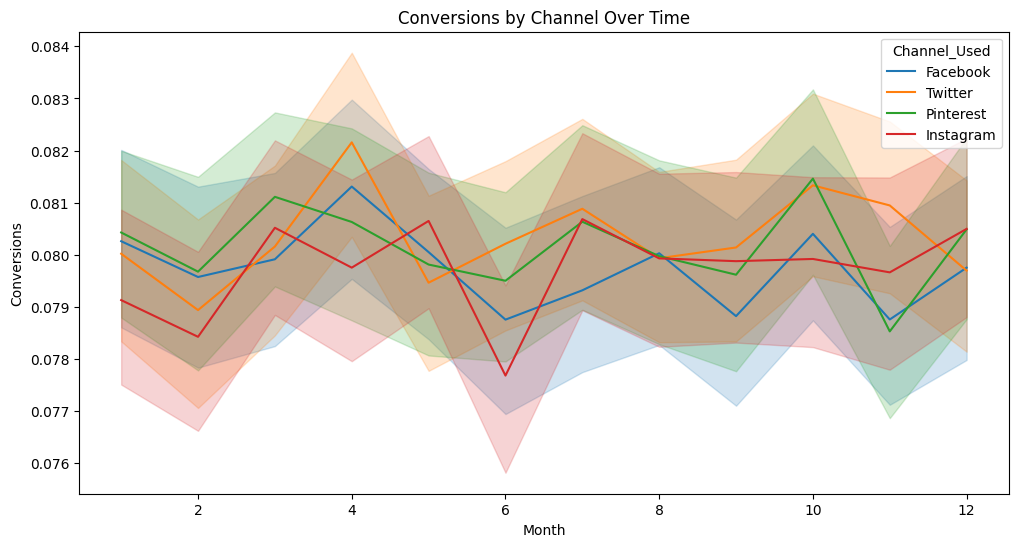

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Conversions by Channel Over Time")
sns.lineplot(data=df_train, x='month', y='Conversion_Rate', hue='Channel_Used')
plt.xlabel('Month')
plt.ylabel('Conversions')
plt.legend(title='Channel_Used')
plt.show()

Checking the conversion rates by apps

In [ ]:
conversion_rate = df_train.pivot_table(values='Conversion_Rate', index='Campaign_Goal', columns='Channel_Used', aggfunc='mean')

In [ ]:
conversion_rate

Channel_Used,Facebook,Instagram,Pinterest,Twitter
Campaign_Goal,,,,
Brand Awareness,0.079683,0.080342,0.080571,0.079766
Increase Sales,0.079867,0.079361,0.079601,0.080593
Market Expansion,0.079500,0.080066,0.080058,0.080446
Product Launch,0.079941,0.079206,0.080440,0.080503


In [23]:
channel_performance = df_train.groupby('Channel_Used')['ROI'].mean().sort_values(ascending=False)
print(channel_performance)

Channel_Used
Twitter      4.004377
Instagram    3.989869
Facebook     3.972527
Pinterest    0.715753
Name: ROI, dtype: float64


In [24]:
location_conversion = df_train.groupby('Location')['Conversion_Rate'].mean()
language_conversion = df_train.groupby('Language')['Conversion_Rate'].mean()
print(location_conversion)
print(language_conversion)

Location
Austin         0.079863
Las Vegas      0.080125
Los Angeles    0.079973
Miami          0.079905
New York       0.080106
Name: Conversion_Rate, dtype: float64
Language
English    0.079933
French     0.080156
Spanish    0.079893
Name: Conversion_Rate, dtype: float64


In [25]:
segment_performance = df_train.groupby('Customer_Segment')['ROI'].mean()
print(segment_performance)

Customer_Segment
Fashion       3.172227
Food          3.161027
Health        3.173938
Home          3.153414
Technology    3.194426
Name: ROI, dtype: float64


In [ ]:
df = df_train.drop(['Campaign_ID','Campaign_Goal', 'Channel_Used', 'Location', 'Language', 'Customer_Segment', 'Company', 'Age_Range', 'month_name', 'Gender_Men', 'Gender_Women'], axis=1)

Model Fitting

GMM

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

for n_components in range(2, 10):
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(df)
    labels = gmm.predict(df)
    silhouette_avg = silhouette_score(df, labels)
    print(f"For n_components={n_components}, the average silhouette_score is: {silhouette_avg}")

For n_components=2, the average silhouette_score is: 0.5133533640691174
For n_components=3, the average silhouette_score is: 0.48868755918410367
For n_components=4, the average silhouette_score is: 0.3809540171046985
For n_components=5, the average silhouette_score is: 0.176500254812881
For n_components=6, the average silhouette_score is: -0.05299896851839705
For n_components=7, the average silhouette_score is: 0.007454462341745207
For n_components=8, the average silhouette_score is: 0.05197962143521714
For n_components=9, the average silhouette_score is: -0.1317319266230767


From the above code we can say that for n=2 components we are getting the best silhouette score means gaussian model fits the best.

K Means

In [ ]:
# wcss = []
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters=i, random_state=42)
#     kmeans.fit(df)
#     wcss.append(kmeans.inertia_)

# plt.plot(range(1, 11), wcss, marker='o')
# plt.title('Elbow Method')
# plt.xlabel('Number of Clusters')
# plt.ylabel('WCSS')
# plt.show()

# optimal_cluster = 3

# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('kmeans', KMeans(n_clusters=optimal_cluster, random_state=42))
# ])

# pipeline.fit(df)

In [ ]:
# cluster_labels = pipeline.named_steps['kmeans'].labels_
# print(cluster_labels)
# pca = PCA(n_components=2)
# df_reduced = pca.fit_transform(pipeline.named_steps['scaler'].transform(df))  # Transform scaled data

# plt.figure(figsize=(8, 6))
# plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=cluster_labels, cmap='viridis', s=50)
# plt.title("Cluster Visualization")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.colorbar(label='Cluster')
# plt.show()
# sil_score = silhouette_score(pipeline.named_steps['scaler'].transform(df), cluster_labels)
# print(f"Silhouette Score: {sil_score}")

DBScan

In [ ]:
# optimal_eps = 0.9
# optimal_min_samples = 10

# pipeline_dbscan = Pipeline([
#     ('scaler', StandardScaler()),
#     ('dbscan', DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples))
# ])


# pipeline_dbscan.fit(df)

# labels = pipeline_dbscan.named_steps['dbscan'].labels_
# print("Cluster Labels:", labels)

In [ ]:
# unique_labels = np.unique(labels)
# num_clusters = len(unique_labels[unique_labels != -1])

In [ ]:
# pca = PCA(n_components=2)
# df_reduced = pca.fit_transform(df)

# # Plot clusters
# plt.figure(figsize=(10, 6))
# unique_labels = np.unique(labels)
# for label in unique_labels:
#     if label == -1:  # Noise points
#         color = 'k'
#         marker = 'x'
#     else:
#         color = plt.cm.nipy_spectral(float(label) / num_clusters)
#         marker = 'o'

#     plt.scatter(
#         df_reduced[labels == label, 0],
#         df_reduced[labels == label, 1],
#         c=[color],
#         label=f"Cluster {label}" if label != -1 else "Noise",
#         marker=marker,
#     )

# plt.title("DBSCAN Clustering")
# plt.xlabel("PCA Component 1")
# plt.ylabel("PCA Component 2")
# plt.legend()
# plt.show()

In [ ]:
# if num_clusters > 1:
#     sil_score = silhouette_score(df, labels)
#     print(f"Silhouette Score: {sil_score}")
# else:
#     print("Silhouette Score cannot be calculated for less than 2 clusters.")